In [1]:
import sys
import joblib
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

import pims # Provides an iterable view of video

#
# Path to CUDA enabled OpenCV
#
sys.path.insert(0,"/project/at073-elderfall/opt/opencv/python/cv2/python-3.6")
import cv2 as cv

#
# Custom OpenCV optical flow python interface
#
# *** Make sure it is on the path! ***
#
from Outil import OpticalFlow
import Outil

print(cv)
print(Outil)

<module 'cv2' from '/project/at073-elderfall/opt/opencv/python/cv2/python-3.6/cv2.cpython-36m-x86_64-linux-gnu.so'>
<module 'Outil' from '/home/jovyan/PLAY/t-opticalflow/export/Python/Outil/__init__.py'>


In [2]:
#
# Optical flow algorithm dispatcher
#
Q = OpticalFlow()

#
# Initial state, no implementation loaded.
#
# "infoPP" pretty prints the state
# "info" returns a dict which you can modify programmatically
#
Q.infoPP()
Q.info()

current:
  algorithm: DualTVL1
  alias: CUDA_DualTVL1_dense
  device: CUDA
  feature: dense
  implementation: cv::cuda::OpticalFlowDual_TVL1
detail: {}



{'current': {'alias': 'CUDA_DualTVL1_dense',
  'feature': 'dense',
  'implementation': 'cv::cuda::OpticalFlowDual_TVL1',
  'algorithm': 'DualTVL1',
  'device': 'CUDA'},
 'detail': {}}

In [3]:
#
# Load default implementation.
#
Q.load()
Q.infoPP()

current:
  algorithm: DualTVL1
  alias: CUDA_DualTVL1_dense
  device: CUDA
  feature: dense
  implementation: cv::cuda::OpticalFlowDual_TVL1
detail:
  CUDA_DualTVL1_dense:
    epsilon: 0.01
    gamma: 0.0
    iterations: 300
    lambda: 0.15
    nscales: 5
    scaleStep: 0.8
    tau: 0.25
    theta: 0.3
    useInitialFlow: false
    warps: 5



In [4]:
#
# List available implementations:
#
#  PS Not all combinations are available.
#
Q.availablePP()
Q.available()

device           :  CUDA , CPU
algorithm        :  DualTVL1 , Farneback , PyrLK
feature          :  dense


{'device': ['CUDA', 'CPU'],
 'algorithm': ['DualTVL1', 'Farneback', 'PyrLK'],
 'feature': ['dense']}

In [5]:
#
# Select a different algorithm on a different device
#
Q.device("CPU").algorithm("Farneback").load()
Q.infoPP()

current:
  algorithm: Farneback
  alias: CPU_Farneback_dense
  device: CPU
  feature: dense
  implementation: cv::FarnebackOpticalFlow
detail:
  CPU_Farneback_dense:
    fastPyramids: false
    flags: 0
    numIters: 10
    numLevels: 5
    polyN: 5
    polySigma: 1.1
    pyrScale: 0.5
    winSize: 13
  CUDA_DualTVL1_dense:
    epsilon: 0.01
    gamma: 0.0
    iterations: 300
    lambda: 0.15
    nscales: 5
    scaleStep: 0.8
    tau: 0.25
    theta: 0.3
    useInitialFlow: false
    warps: 5



In [6]:
#
# Let's go back to Dual TVL1
#
Q.device("CUDA").algorithm("DualTVL1") # already loaded

#
# Initialize kernel, optionally with alternative parameter values.
#
Q.kernel({"iterations": 30, "warps": 5})

Q.infoPP(False)

current:
  algorithm: DualTVL1
  alias: CUDA_DualTVL1_dense
  device: CUDA
  feature: dense
  implementation: cv::cuda::OpticalFlowDual_TVL1
detail:
  CUDA_DualTVL1_dense:
    epsilon: 0.01
    gamma: 0.0
    iterations: 30
    lambda: 0.15
    nscales: 5
    scaleStep: 0.8
    tau: 0.25
    theta: 0.3
    useInitialFlow: false
    warps: 5



In [7]:
#data_path="/project/at073-elderfall/opt/contrib/Outil/data/OpticalFlow"
data_path="Outil/data/OpticalFlow"

vid = pims.PyAVReaderTimed(f'{data_path}/VID/2.mp4')

#
# Rounding error with:
#
#  [cv.imread(f'{data_path}/IMG/{_}.png',cv.IMREAD_GRAYSCALE) for _ in [336,337,338]]
#
# However, this is fine:
#
#  [ cv.cvtColor(cv.imread(f'{data_path}/IMG/{_}.png',cv.IMREAD_COLOR),cv.COLOR_BGR2GRAY) for _ in [336,337,338]]
#
img = [ cv.cvtColor(vid[_],cv.COLOR_RGB2GRAY) for _ in [335,336,337]]

/opt/conda/lib/python3.6/site-packages/pims/pyav_reader.py:252: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


In [8]:
#
# Calculate optical flow. Result is a list of differences between
# adjacent frames. "wrap" takes the difference between the last and
# the first images in that order.
#
flow, elapsed = Q(img,wrap=True)
print(f'{len(flow)} diffs calculated. Time taken {elapsed} secs')

#
# Alternatively, with only two images
#
flow, elapsed = Q(img[0],img[1])
print(f'{len(flow)} diffs calculated. Time taken {elapsed} secs')

3 diffs calculated. Time taken 0.612119637 secs
1 diffs calculated. Time taken 0.141987005 secs


In [9]:
img = [ cv.cvtColor(_,cv.COLOR_RGB2GRAY) for _ in vid]

/opt/conda/lib/python3.6/site-packages/pims/pyav_reader.py:252: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


In [10]:
img[327]

array([[131, 131, 131, ...,  96,  96,  96],
       [131, 131, 131, ...,  96,  96,  96],
       [131, 131, 131, ...,  96,  96,  96],
       ...,
       [ 37,  47,  62, ..., 174, 174, 174],
       [ 46,  47,  57, ..., 174, 174, 174],
       [ 48,  47,  53, ..., 174, 174, 174]], dtype=uint8)

In [11]:
flow, elapsed = Q(img,wrap=True)
print(f'{len(flow)} diffs calculated. Time taken {elapsed} secs')

518 diffs calculated. Time taken 39.50970186299999 secs


In [12]:
def optical_flow_viewer(flow):
 
 m = flow[...,0]**2 + flow[...,1]**2
 _ = (np.min(m),np.max(m))

 r = np.int0((m-_[0])*255/(_[1]-_[0])+0.5)

 plot.imshow(r)

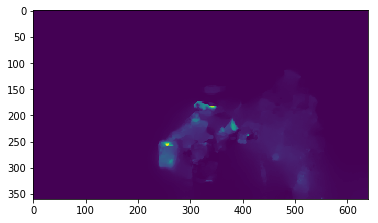

In [13]:
optical_flow_viewer(flow[357])